/home/lachlan/.pyenv/versions/3.10.6/envs/venv_xfmread/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lachlan/.pyenv/versions/3.10.6/envs/venv_xfmread/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lachlan/.pyenv/versions/

-----------------
BEGIN reading processed data
Location: /home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/carlos_full
-----
Map files found: 28
Elements identified: ['AgL', 'Al', 'As', 'AuL', 'Back', 'Ca', 'Cl', 'Compton', 'Cr', 'Cu', 'Fe', 'K', 'Mg', 'Mn', 'Mo', 'MoL', 'Ni', 'P', 'Rb', 'S', 'Si', 'Sr', 'Ti', 'V', 'Y', 'Zn', 'Zr', 'sum']
-----------------
READING MAP DATA
Initial shape: (555, 1200, 28)
Revised shape: (554, 1200, 28)
-----
-----------------
READING VARIANCE DATA
Initial shape: (278, 600, 28)
Revised shape: (278, 600, 28)
-----
averaging channel 0, cycle 0 -- dataq99: 25860.578, sdq2: 22542.371, ratio: 2.294
averaging channel 0, cycle 1 -- dataq99: 11565.203, sdq2: 9094.293, ratio: 2.543
averaging channel 0, cycle 2 -- dataq99: 5172.116, sdq2: 7654.816, ratio: 1.351
averaging channel 2, cycle 0 -- dataq99: 971.147, sdq2: 1411.090, ratio: 1.376
averaging channel 6, cycle 0 -- dataq99: 22380.912, sdq2: 28109.883, ratio: 1.592
averaging channel 7, cycle 0 -- dataq99: 0

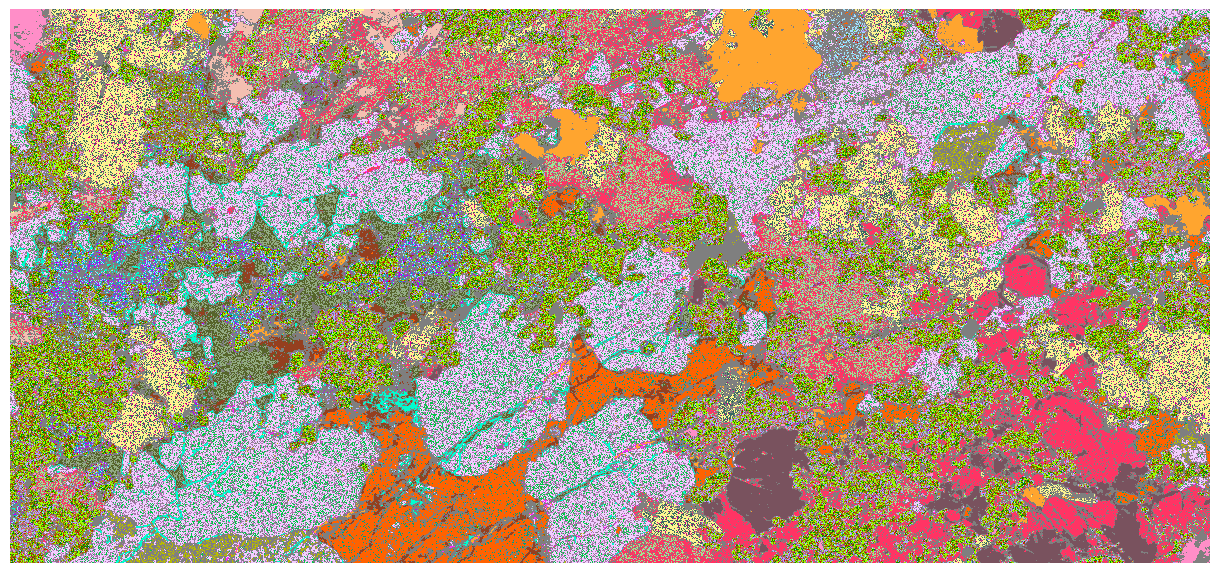

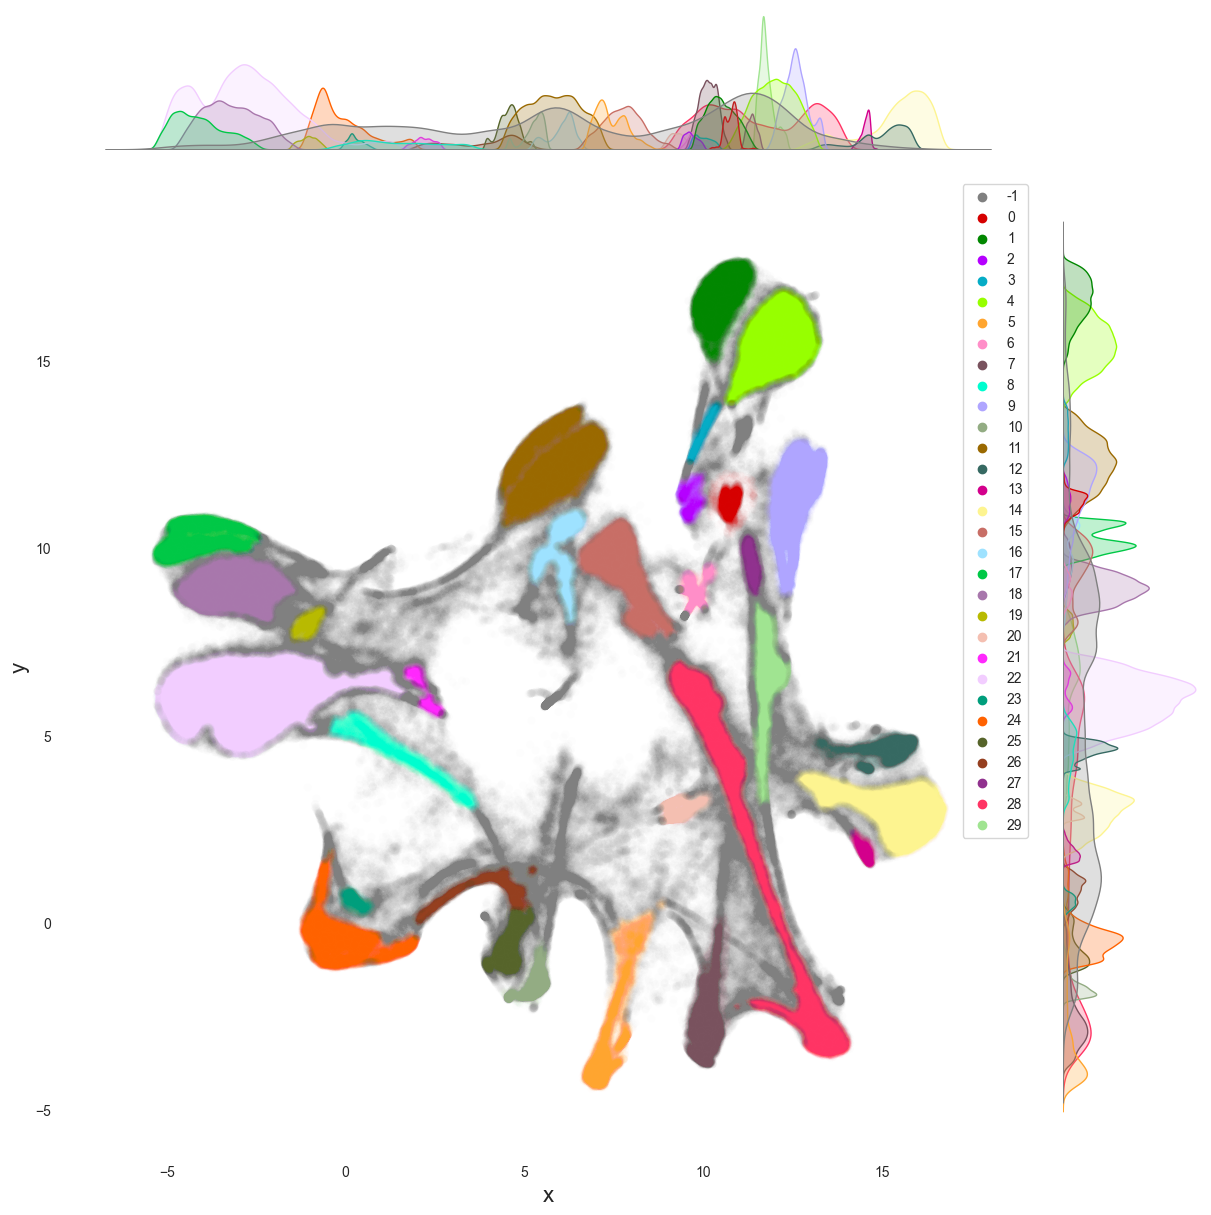

In [1]:
import time
import sys
import os
import numpy as np

%load_ext autoreload
%autoreload 2

import xfmreadout.utils as utils
import xfmreadout.argops as argops
import xfmreadout.clustering as clustering
import xfmreadout.visualisations as vis
import xfmreadout.processops as processops
import xfmreadout.structures as structures
import xfmreadout.entry_processed as entry_processed

#add the parent folder to sys path so we can import from the notebook subfolder
sys.path.insert(0,'..')

#args = ' -d /home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo_short -n 2'
args = ["-d", "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/carlos_full", "-n", "2",]

pxs, embedding, categories, classavg, palette = entry_processed.read_processed(args)




In [2]:
embedding__ = np.copy(embedding)
embedding__ = embedding__-np.min(embedding)




In [3]:
import seaborn as sns
import colorcet as cc
from sklearn.preprocessing import normalize

def cluster_colourmap(embedding, categories):
    """
    create a colourmap clustered onto an embedding
    """
    GREY=( 0.5, 0.5, 0.5 )

    cat_min=np.min(categories)
    cat_max=np.max(categories)
    num_cats=cat_max-cat_min+1
    num_colours = num_cats*3

    palette = sns.color_palette(cc.glasbey_light,num_colours)
    colours = np.array(palette, dtype=np.float32)



    # produce 2D embedding for visualisation
    ___, colour_embedding = clustering.reduce(colours, "UMAP", target_components=2) 
    
    colour_embedding__ = np.copy(colour_embedding)
    colour_embedding__ = colour_embedding__-np.min(colour_embedding__)    

    return palette, colour_embedding

newpalette, colour_embedding = cluster_colourmap(embedding, categories) 

if False:
    """
    TO DO: normalise onto embedding scale
    """
    centroids = utils.compile_centroids(embedding, categories)

    """
    TO DO:
    assign embedding points to colours
    """


running reducer: UMAP across data with shape: (93, 3)
UMAP(n_neighbors=30, verbose=True)
Tue Aug  1 16:32:09 2023 Construct fuzzy simplicial set
Tue Aug  1 16:32:09 2023 Finding Nearest Neighbors
Tue Aug  1 16:32:12 2023 Finished Nearest Neighbor Search
Tue Aug  1 16:32:15 2023 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:02]

Tue Aug  1 16:32:17 2023 Finished embedding


In [18]:
def norm_onto(colour_embedding, embedding):
    """
    normalise one 2D array of values onto the other, by axis
    """

    embedding__ = np.copy(embedding)
    colour_embedding__ = np.copy(colour_embedding)

    for i in range(embedding.shape[1]):
        embedding__[:,i] = embedding__[:,i]-np.min(embedding[:,i])

        colour_embedding__[:,i] = np.copy(colour_embedding[:,i])
        colour_embedding__[:,i] = colour_embedding__[:,i]-np.min(colour_embedding__[:,i])   

        colour_embedding__[:,i] = colour_embedding__[:,i]/np.max(colour_embedding__[:,i])
        colour_embedding__[:,i] = colour_embedding__[:,i]*np.max(embedding__[:,i])
        colour_embedding__[:,i] = colour_embedding__[:,i]+np.min(embedding[:,i])

    return colour_embedding__


normed = norm_onto(colour_embedding, embedding)

palcat = np.arange(0,normed.shape[0])



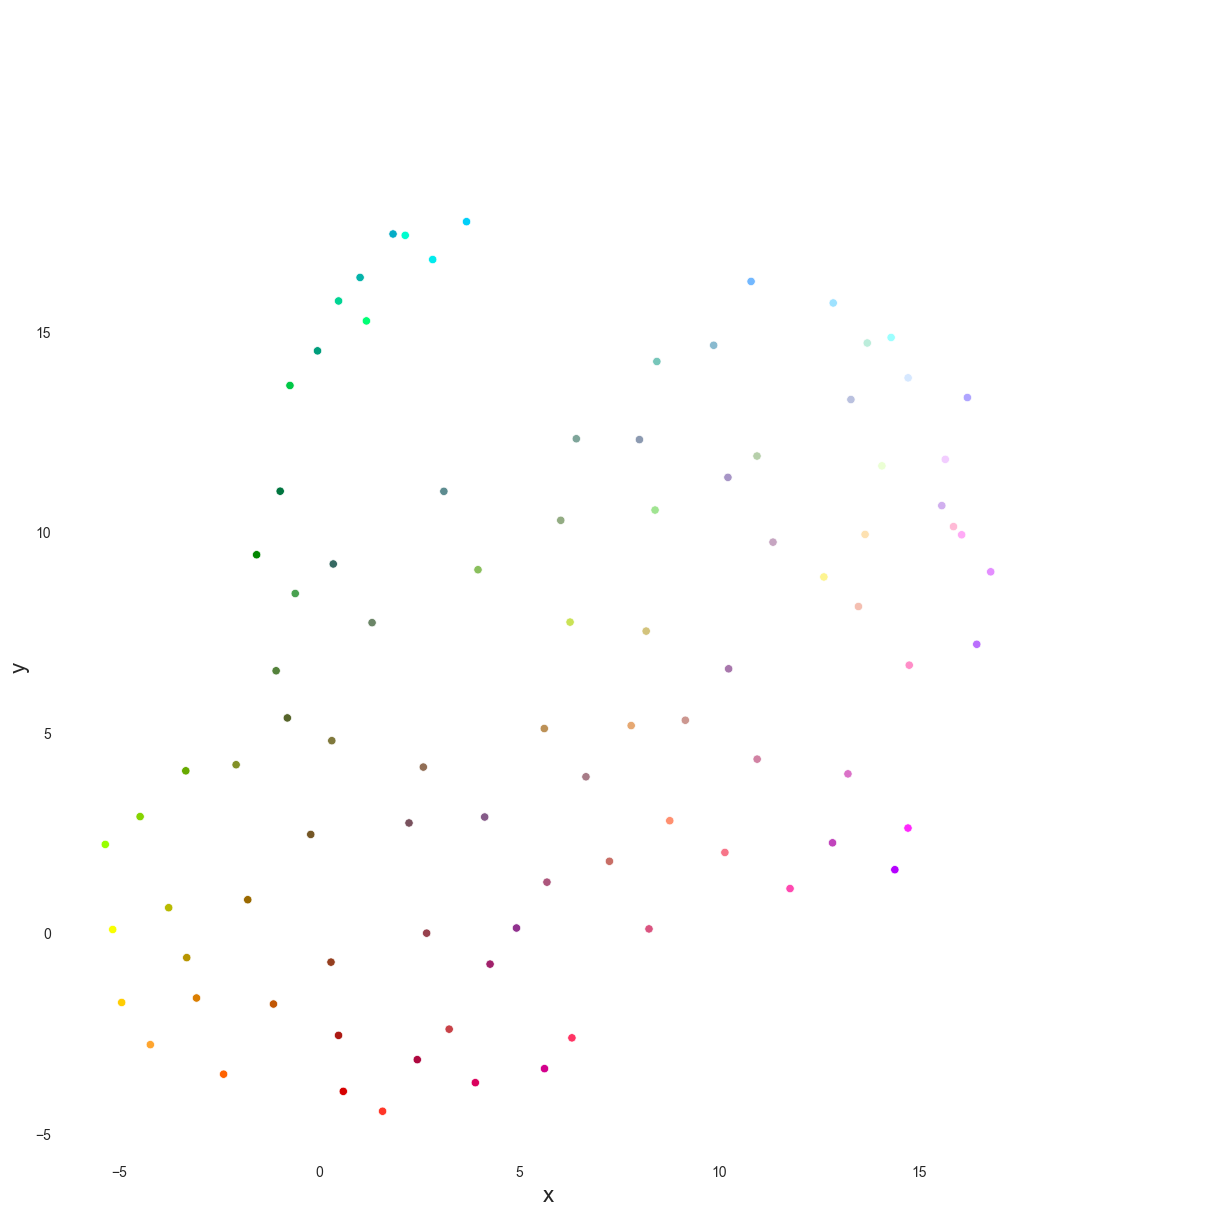

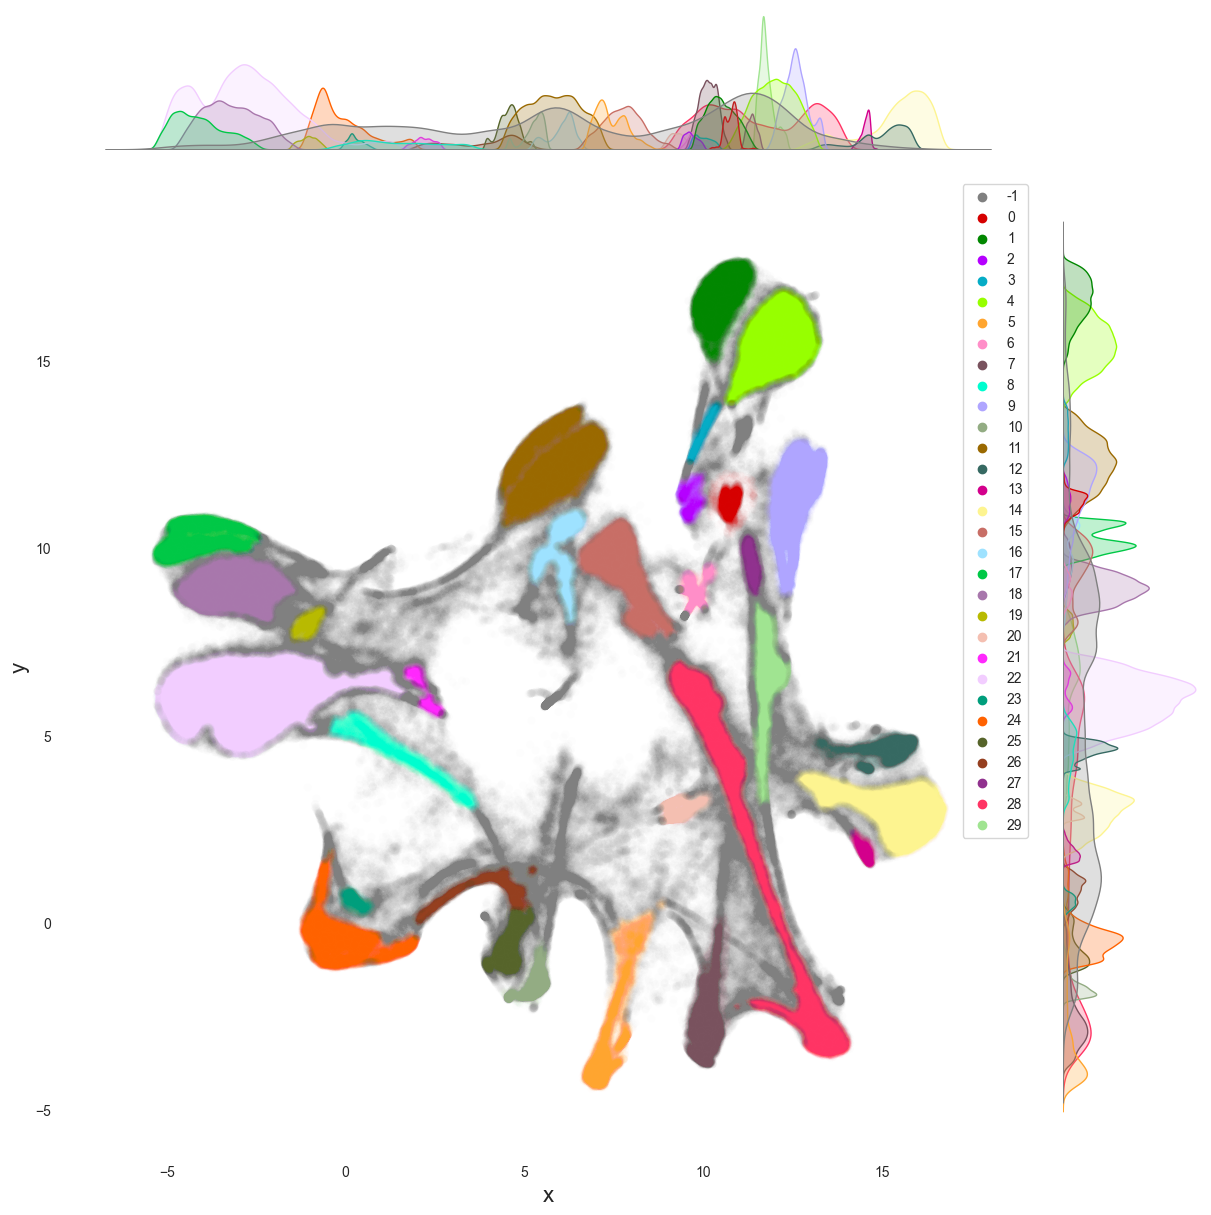

In [19]:
def new_embedplot(embedding, categories, palette):
    x=embedding.T[0]
    y=embedding.T[1]

    ### scatter plot with marginal axes
    sns.set_style('white')

    embed_plot = sns.jointplot(x=x, y=y,
                hue=categories, palette=palette,
                lw=0,
                joint_kws = dict(alpha=1.0),
                height=12, ratio=6
                )

    #xlim=[-3,3], ylim=[-3,3],

    embed_plot.set_axis_labels('x', 'y', fontsize=16)

    embed_plot.ax_joint.legend_.remove()

    sns.despine(ax=None, left=True, bottom=True)
    fig = embed_plot.fig


new_embedplot(normed, palcat, newpalette)

fig = vis.seaborn_embedplot(embedding, categories, palette=palette)

In [20]:
def get_closest_points(normed, centroids):
    closest = np.zeros(centroids.shape[0], dtype=np.int32)

    for i in range(centroids.shape[0]):
        print(i)
        matrix = normed-centroids[i,:]
        dist = matrix[:,0]**2 + matrix[:,1]**2

        #result = int(np.where(dist==np.min(dist))[0][0])
        j=0
        partn = np.partition(dist, j)[j]
        result = int(np.where(dist==partn)[0][0])

        while result in closest:
            print(f"{result} in closest")
            partn = np.partition(dist, j)[j]
            result = int(np.where(dist==partn)[0][0])
            j+=1

        print(f"using {result}")
        closest[i] = result

    return closest

centroids = utils.compile_centroids(embedding, categories)

closest = get_closest_points(normed, centroids)

closest.shape, centroids.shape[0], np.min(categories), np.max(categories), np.max(categories)-np.min(categories)

#closest = array of indexes corresponding to closest colour, without replacement

#TO-DO generate an ordered palette from these indexes






0
using 34
1
using 81
2
using 36
3
81 in closest
81 in closest
using 74
4
74 in closest
74 in closest
using 72
5
using 16
6
using 28
7
using 37
8
using 87
9
using 42
10
using 65
11
using 70
12
using 82
13
using 67
14
using 2
15
using 21
16
using 29
17
using 10
18
using 1
19
1 in closest
1 in closest
using 55
20
55 in closest
55 in closest
using 84
21
using 38
22
using 41
23
84 in closest
84 in closest
using 31
24
using 26
25
26 in closest
26 in closest
using 48
26
70 in closest
70 in closest
using 27
27
27 in closest
27 in closest
using 75
28
37 in closest
37 in closest
using 14
29
using 47
30
using 18


((31,), 31, -1, 29, 30)

In [35]:
import copy

final_palette = copy.deepcopy(newpalette)

j=0
for i in closest:
    print(i)
    if j == 0:
        final_palette = newpalette[i:i]
    else:
        final_palette.append(newpalette[i])
    j+=1

type(palette)

34
81
36
74
72
16
28
37
87
42
65
70
82
67
2
21
29
10
1
55
84
38
41
31
26
48
27
75
14
47
18


seaborn.palettes._ColorPalette